In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from circuit_toolkit.Optimizers import CholeskyCMAES_torch
from tqdm.auto import trange

c:\users\lio50\github\circuit_toolkit\circuit_toolkit\GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


### Define invertible layers


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RealNVP2D(nn.Module):
    """
    A single RealNVP-like coupling layer in 2D, splitting x into (x1, x2):
        x1' = x1
        x2' = x2 * exp(s(x1)) + t(x1)
    with a small MLP to learn s and t.
    """
    def __init__(self, hidden_dim=16):
        super().__init__()
        # We create a small neural network that takes x1 as input (1D)
        # and outputs scale and shift (each 1D).
        # For simplicity, we do a 2-layer MLP: 1 -> hidden_dim -> 2
        # The output dimension is 2 => (s, t)
        
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)  # final layer outputs [s, t]

        )
        
    def forward(self, x, reverse=False, ):
        """
        Forward or inverse pass.
        

        Args:
            x: Tensor of shape (batch, 2).
            reverse: bool. If False, apply forward transform x -> x'.
                     If True, apply inverse transform x' -> x.
        
        Returns:
            x_out: transformed tensor (batch, 2).
            log_det: log determinant of the Jacobian of the transform, 
                     shape (batch,).
        """
        x1 = x[:, 0:1]  # shape (batch, 1)
        x2 = x[:, 1:2]  # shape (batch, 1)
        
        # Compute scale and shift from x1
        st = self.net(x1)  # shape (batch, 2)
        s = st[:, 0:1]      # scale
        t = st[:, 1:2]      # shift
        
        if not reverse:
            # forward: x2' = x2 * exp(s) + t
            x2_out = x2 * torch.exp(s) + t
            x_out = torch.cat([x1, x2_out], dim=1)
            
            # log determinant = sum of log|scale| for each dimension of x2
            # here it's just 1D, so log_det = s
            log_det = s.squeeze(dim=1)  # shape (batch,)
            
        else:
            # inverse: x2 = (x2' - t) * exp(-s)
            x2_out = (x2 - t) * torch.exp(-s)
            x_out = torch.cat([x1, x2_out], dim=1)
            
            # For inverse, the log_det is -s (since determinant is inverse scale)
            log_det = -s.squeeze(dim=1)
        
        return x_out, log_det

import torch
import torch.nn as nn

class RealNVP2DStabilized(nn.Module):
    """
    A RealNVP-like coupling layer in 2D with a stabilization trick,
    splitting x into (x1, x2):
        x1' = x1
        x2' = x2 * exp(s) + t
    where s is scaled/stabilized.
    """
    def __init__(self, hidden_dim=16):
        super().__init__()
        
        # Small neural network that takes x1 as input (1D)
        # and outputs [s, t] (each 1D).
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)  # final layer outputs [s, t]
        )

        # A trainable scaling factor to stabilize the learned s
        # Start with zero => s_fac = e^0 = 1.0 initially
        self.scaling_factor = nn.Parameter(torch.zeros(1))

    def forward(self, x, reverse=False):
        """
        Forward or inverse pass.
        
        Args:
            x: Tensor of shape (batch, 2).
            reverse: bool. If False, apply forward transform x -> x'. 
                     If True, apply inverse transform x' -> x.
        
        Returns:
            x_out: transformed tensor (batch, 2).
            log_det: log determinant of the Jacobian of the transform, 
                     shape (batch,).
        """
        x1 = x[:, 0:1]  # shape (batch, 1)
        x2 = x[:, 1:2]  # shape (batch, 1)
        
        # Compute scale and shift from x1
        st = self.net(x1)      # shape (batch, 2)
        s = st[:, 0:1]         # scale (raw)
        t = st[:, 1:2]         # shift

        # Stabilize the scale parameter s
        # 1) Exponentiate scaling_factor => s_fac
        # 2) Scale raw s by 1/s_fac, squash with tanh,
        # 3) multiply back by s_fac
        s_fac = self.scaling_factor.exp()  # shape: () scalar
        s = torch.tanh(s / s_fac) * s_fac

        if not reverse:
            # forward: x2' = x2 * exp(s) + t
            x2_out = x2 * torch.exp(s) + t
            x_out = torch.cat([x1, x2_out], dim=1)

            # log determinant = sum of log|scale| for each dimension (1D)
            log_det = s.squeeze(dim=1)
        else:
            # inverse: x2 = (x2' - t) * exp(-s)
            x2_out = (x2 - t) * torch.exp(-s)
            x_out = torch.cat([x1, x2_out], dim=1)

            # for inverse, log_det = -s
            log_det = -s.squeeze(dim=1)

        return x_out, log_det



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RealNVPND(nn.Module):
    """
    A single RealNVP-like coupling layer in N dimensions (N must be even),
    splitting x into (x1, x2) each of dimension N/2:
        x1' = x1
        x2' = x2 * exp(s(x1)) + t(x1)
    with a small MLP to learn s and t.
    """
    def __init__(self, dim, hidden_dim=16):
        super().__init__()
        assert dim % 2 == 0, "Input dimension must be even"
        self.dim = dim
        self.split_dim = dim // 2
        
        # Neural network that takes x1 as input (N/2 dim)
        # and outputs scale and shift (each N/2 dim)
        self.net = nn.Sequential(
            nn.Linear(self.split_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, self.split_dim * 2)  # outputs [s, t] each N/2 dim
        )
        
    def forward(self, x, reverse=False):
        """
        Forward or inverse pass.
        
        Args:
            x: Tensor of shape (batch, N).
            reverse: bool. If False, apply forward transform x -> x'.
                     If True, apply inverse transform x' -> x.
        
        Returns:
            x_out: transformed tensor (batch, N).
            log_det: log determinant of the Jacobian of the transform, 
                     shape (batch,).
        """
        x1 = x[:, :self.split_dim]  # shape (batch, N/2)
        x2 = x[:, self.split_dim:]  # shape (batch, N/2)
        
        # Compute scale and shift from x1
        st = self.net(x1)  # shape (batch, N)
        s = st[:, :self.split_dim]      # scale
        t = st[:, self.split_dim:]      # shift
        
        if not reverse:
            # forward: x2' = x2 * exp(s) + t
            x2_out = x2 * torch.exp(s) + t
            x_out = torch.cat([x1, x2_out], dim=1)
            
            # log determinant = sum of log|scale| for each dimension of x2
            log_det = s.sum(dim=1)  # shape (batch,)
            
        else:
            # inverse: x2 = (x2' - t) * exp(-s)
            x2_out = (x2 - t) * torch.exp(-s)
            x_out = torch.cat([x1, x2_out], dim=1)
            
            # For inverse, the log_det is -sum(s)
            log_det = -s.sum(dim=1)
        
        return x_out, log_det

class RealNVPNDStabilized(nn.Module):
    """
    A RealNVP-like coupling layer in N dimensions (N must be even) with a stabilization trick,
    splitting x into (x1, x2) each of dimension N/2:
        x1' = x1
        x2' = x2 * exp(s) + t
    where s is scaled/stabilized.
    """
    def __init__(self, dim, hidden_dim=16):
        super().__init__()
        assert dim % 2 == 0, "Input dimension must be even"
        self.dim = dim
        self.split_dim = dim // 2
        
        # Neural network that takes x1 as input (N/2 dim)
        # and outputs scale and shift (each N/2 dim)
        self.net = nn.Sequential(
            nn.Linear(self.split_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, self.split_dim * 2)  # outputs [s, t] each N/2 dim
        )

        # A trainable scaling factor to stabilize the learned s
        # Start with zero => s_fac = e^0 = 1.0 initially
        self.scaling_factor = nn.Parameter(torch.zeros(1))

    def forward(self, x, reverse=False):
        """
        Forward or inverse pass.
        
        Args:
            x: Tensor of shape (batch, N).
            reverse: bool. If False, apply forward transform x -> x'. 
                     If True, apply inverse transform x' -> x.
        
        Returns:
            x_out: transformed tensor (batch, N).
            log_det: log determinant of the Jacobian of the transform, 
                     shape (batch,).
        """
        x1 = x[:, :self.split_dim]  # shape (batch, N/2)
        x2 = x[:, self.split_dim:]  # shape (batch, N/2)
        
        # Compute scale and shift from x1
        st = self.net(x1)      # shape (batch, N)
        s = st[:, :self.split_dim]         # scale (raw)
        t = st[:, self.split_dim:]         # shift

        # Stabilize the scale parameter s
        # 1) Exponentiate scaling_factor => s_fac
        # 2) Scale raw s by 1/s_fac, squash with tanh,
        # 3) multiply back by s_fac
        s_fac = self.scaling_factor.exp()  # shape: () scalar
        s = torch.tanh(s / s_fac) * s_fac

        if not reverse:
            # forward: x2' = x2 * exp(s) + t
            x2_out = x2 * torch.exp(s) + t
            x_out = torch.cat([x1, x2_out], dim=1)

            # log determinant = sum of log|scale| for each dimension
            log_det = s.sum(dim=1)
        else:
            # inverse: x2 = (x2' - t) * exp(-s)
            x2_out = (x2 - t) * torch.exp(-s)
            x_out = torch.cat([x1, x2_out], dim=1)

            # for inverse, log_det = -sum(s)
            log_det = -s.sum(dim=1)

        return x_out, log_det


In [4]:

import torch
import torch.nn as nn

class InvertibleLinear2D(nn.Module):
    """
    A learnable 2x2 invertible linear transform:
        z = x @ W
      log|det J| = log|det(W)|
    Inverse:
        x = z @ W^-1
      log|det J| = -log|det(W)|
    """
    def __init__(self):
        super().__init__()
        # Create a 2x2 parameter
        # Initialize with something invertible
        W_init = torch.randn(2, 2) * 0.1
        if torch.det(W_init).abs() < 1e-5:
            # re-init or add identity for safety
            W_init = W_init + 0.5 * torch.eye(2)
        
        self.W = nn.Parameter(W_init)  # shape (2, 2)

    def forward(self, x, reverse=False):
        """
        x: (batch, 2) or (N,2)
        reverse: bool, if True apply inverse transform
        Returns: x_out, log_det (batch,) 
        """
        # shape (2,2)
        W_mat = self.W
        
        # Pre-compute log-det|W|
        # We do it once per forward call; it’s a constant w.r.t. batch dimension
        det_val = torch.det(W_mat)
        if det_val.abs() < 1e-12:
            # (Optional) In real code, might clamp or reparam to avoid singularities
            # For demonstration, we just proceed. 
            pass
        log_abs_det = torch.log(torch.abs(det_val) + 1e-12)
        
        if not reverse:
            # Forward: z = x * W
            x_out = x @ W_mat  # shape (batch,2)
            log_det = log_abs_det.repeat(x.size(0))  # replicate for each sample
        else:
            # Inverse: x = z * W^-1
            W_inv = torch.inverse(W_mat)
            x_out = x @ W_inv
            # log-det of the inverse is the negative of log-det(W)
            log_det = -log_abs_det.repeat(x.size(0))
        
        return x_out, log_det


class Orthogonal2D(nn.Module):
    """
    A 2D orthogonal transform M in O(2):
      - A learnable angle 'theta' for rotation.
      - A fixed boolean 'reflection' that, if True, multiplies by diag(1, -1).
    The determinant is either +1 (rotation only) or -1 (with reflection), and
    |det(M)| = 1 => log|det(M)| = 0.
    
    Forward pass (reverse=False):   z = x @ M
    Inverse pass (reverse=True):    x = z @ M^T
    """
    def __init__(self, reflection=False, random_init=False, shift=False):
        """
        Args:
          reflection: bool, whether to apply reflection as well.

        """
        super().__init__()
        # We'll learn a single angle theta. Initialize at 0 => identity transform.
        self.theta = nn.Parameter(torch.zeros(1))
        if random_init:
            self.theta.data = torch.rand(1) * 2 * torch.pi
        self.reflection = reflection
        self.shift = shift
        if shift:
            self.offset = nn.Parameter(torch.zeros(2))
            if random_init:
                self.offset.data = torch.randn(2)
        else:
            self.offset = None


    def forward(self, x, reverse=False):
        """
        x: Tensor of shape (batch, 2).
        reverse: bool => if True, apply the inverse transform (i.e. multiply by M^T).
        Returns: (x_out, log_abs_det), 
                 x_out = x*M or x*M^T, 
                 log_abs_det = 0 for all samples.
        """
        # Compute rotation matrix from theta
        cos_theta = torch.cos(self.theta)
        sin_theta = torch.sin(self.theta)
        # Construct R(\theta)
        # shape: (2,2)
        R = torch.stack([
            torch.cat([cos_theta, -sin_theta], dim=0),
            torch.cat([sin_theta,  cos_theta], dim=0)
        ], dim=0)  # Overall shape (2,2)

        # If reflection=True, multiply by diag(1, -1) => determinant = -1
        if self.reflection:
            # D = [[1, 0], [0, -1]]
            D = torch.diag(torch.tensor([1., -1.], device=x.device, dtype=x.dtype))
            M = D @ R   # shape (2,2), det(M) = -1
        else:
            M = R       # shape (2,2), det(M) = +1

        if not reverse:
            # Forward pass => z = x @ M
            x_out = x @ M
            if self.shift:
                x_out += self.offset
        else:
            # Inverse pass => x = z @ M^T = z @ inverse(M), 

            # but for orthonormal M, inverse(M) = M^T
            if self.shift:
                x -= self.offset
            x_out = x @ M.t()

        # For orthonormal M, |det(M)|=1 => log|det(M)|=0
        log_abs_det = torch.zeros(x.size(0), device=x.device)
        return x_out, log_abs_det



# create a model composed of 4 coupling layers, alternating between x1 and x2, interleaving a layer swapping x1 and x2

# class RealNVP_stack(nn.Module):
#     def __init__(self, hidden_dim=16, stack_size=4):
#         super().__init__()
#         self.coupling_layers = nn.ModuleList([RealNVP2D(hidden_dim) for _ in range(stack_size)])
#         # Create a permutation matrix that swaps x1 and x2
#         self.swap_layer = nn.Linear(2, 2, bias=False)
#         self.swap_layer.weight.data = torch.tensor([[0., 1.], [1., 0.]])  # Permutation matrix to swap dimensions

#     def forward(self, x, reverse=False):
#         log_det_total = 0.0
#         if not reverse:
#             for i, layer in enumerate(self.coupling_layers):
#                 x, log_det = layer(x, False)
#                 log_det_total += log_det
#                 x, log_det = self.swap_layer(x), 0.0
#                 log_det_total += log_det
#         else:
#             for i, layer in enumerate(self.coupling_layers[::-1]):
#                 x, log_det = self.swap_layer(x), 0.0
#                 log_det_total += log_det
#                 x, log_det = layer(x, True)
#                 log_det_total += log_det

#         return x, log_det_total
    
    


In [5]:
import torch
import torch.nn as nn

class InvertibleLinearND(nn.Module):
    """
    An N-dimensional invertible linear transform:
        z = x @ W
      log|det J| = log|det(W)|
    Inverse:
        x = z @ W^-1
      log|det J| = -log|det(W)|
    """
    def __init__(self, dim, dtype=torch.float):
        super().__init__()
        self.dim = dim
        # Create a dim x dim parameter
        # Initialize with something invertible
        W_init = torch.randn(dim, dim, dtype=dtype) * 0.1
        if torch.det(W_init).abs() < 1e-5:
            # re-init or add identity for safety
            W_init = W_init + 0.5 * torch.eye(dim, dtype=dtype)
        
        self.W = nn.Parameter(W_init)  # shape (dim, dim)
        #TODO: compute inverse prehand

    def forward(self, x, reverse=False):
        """
        x: (batch, dim) or (N,dim)
        reverse: bool, if True apply inverse transform
        Returns: x_out, log_det (batch,) 
        """
        # shape (dim,dim)
        W_mat = self.W
        
        # Pre-compute log-det|W|
        det_val = torch.det(W_mat)
        if det_val.abs() < 1e-12:
            pass
        log_abs_det = torch.log(torch.abs(det_val) + 1e-12)
        
        if not reverse:
            # Forward: z = x * W
            x_out = x @ W_mat  # shape (batch,dim)
            log_det = log_abs_det.repeat(x.size(0))  # replicate for each sample
        else:
            # Inverse: x = z * W^-1
            W_inv = torch.inverse(W_mat)
            x_out = x @ W_inv
            log_det = -log_abs_det.repeat(x.size(0))
        
        return x_out, log_det

class OrthogonalND(nn.Module):
    """
    An N-dimensional orthogonal transform using a random orthogonal matrix.
    The determinant is ±1 so log|det(M)| = 0.
    """
    def __init__(self, dim, random_init=True, shift=False, allow_reflect=False, dtype=torch.float):
        """
        Args:
          dim: int, dimension of the transform
          random_init: bool, whether to randomly initialize the matrix
          shift: bool, whether to add a learnable shift
        """
        super().__init__()
        self.dim = dim
        
        # Initialize random orthogonal matrix using QR decomposition
        if random_init:
            A = torch.randn(dim, dim, dtype=dtype)
            Q, R = torch.linalg.qr(A)
            # Make Q have determinant 1
            if not allow_reflect:
                d = torch.diag(R).sign()
                Q *= d.unsqueeze(0)
        else:
            Q = torch.eye(dim, dtype=dtype)
            
        self.M = nn.Parameter(Q)
        
        self.shift = shift
        if shift:
            self.offset = nn.Parameter(torch.zeros(dim, dtype=dtype))
            if random_init:
                self.offset.data = torch.randn(dim, dtype=dtype)
        else:
            self.offset = None

    def forward(self, x, reverse=False):
        """
        x: Tensor of shape (batch, dim)
        reverse: bool => if True, apply inverse transform
        Returns: (x_out, log_abs_det)
        """
        if not reverse:
            x_out = x @ self.M
            if self.shift:
                x_out += self.offset
        else:
            if self.shift:
                x = x - self.offset
            x_out = x @ self.M.t()  # M^T = M^{-1} for orthogonal matrices

        # For orthogonal M, |det(M)|=1 => log|det(M)|=0
        log_abs_det = torch.zeros(x.size(0), device=x.device)
        return x_out, log_abs_det


In [6]:

class RealNVP_stack(nn.Module):
    """
    A stack of RealNVP2D coupling layers, each followed by
    its own invertible linear transform in 2D.
    """
    def __init__(self, hidden_dim=16, stack_size=4, linear_type="general", stabilized=False):
        super().__init__()
        # Create coupling layers.
        # We'll alternate the 'mask_first' so that different dims
        # are the "active" dimension across layers.
        self.coupling_layers = nn.ModuleList([
            RealNVP2DStabilized(hidden_dim, ) if stabilized else RealNVP2D(hidden_dim)
            for i in range(stack_size)
        ])

        # Create an invertible linear transform after each coupling layer
        if linear_type == "general":
            self.linear_layers = nn.ModuleList([
                InvertibleLinear2D() for _ in range(stack_size)
            ])
        elif linear_type == "orthogonal_shift":
            self.linear_layers = nn.ModuleList([
                Orthogonal2D(reflection=True if i % 2 == 0 else False, random_init=True, shift=True) for i in range(stack_size)
            ])
        elif linear_type == "orthogonal":

            self.linear_layers = nn.ModuleList([
                Orthogonal2D(reflection=True if i % 2 == 0 else False, random_init=True, shift=False) for i in range(stack_size)
            ])
        elif linear_type == "special_orthogonal":
            self.linear_layers = nn.ModuleList([
                Orthogonal2D(reflection=False, random_init=True, shift=False) for _ in range(stack_size)
            ])
        else:
            raise ValueError(f"Invalid linear_type: {linear_type}")

        self.stack_size = stack_size

    def forward(self, x, reverse=False):
        """
        x: (batch, 2)
        reverse: whether to apply the inverse pass
        Returns: (x_out, total_log_det)
        """
        log_det_total = torch.zeros(x.size(0), device=x.device)
        
        if not reverse:
            # Forward pass
            # For i in [0..stack_size-1]:
            #   x, ld_coup = coupling_layers[i](x, False)
            #   x, ld_lin  = linear_layers[i](x, False)
            #   accumulate log_det
            for i in range(self.stack_size):
                x, ld_coup = self.coupling_layers[i](x, reverse=False)
                log_det_total += ld_coup
                x, ld_lin = self.linear_layers[i](x, reverse=False)
                log_det_total += ld_lin
        else:
            # Inverse pass
            # We go in reverse order:
            #   x, ld_lin  = linear_layers[i]  (x, True)
            #   x, ld_coup = coupling_layers[i](x, True)
            for i in reversed(range(self.stack_size)):
                x, ld_lin = self.linear_layers[i](x, reverse=True)
                log_det_total += ld_lin
                x, ld_coup = self.coupling_layers[i](x, reverse=True)
                log_det_total += ld_coup

        return x, log_det_total

In [7]:

class RealNVPND_stack(nn.Module):
    """
    A stack of RealNVP2D coupling layers, each followed by
    its own invertible linear transform in 2D.
    """
    def __init__(self, dim, hidden_dim=16, stack_size=4, linear_type="general", stabilized=False, dtype=torch.float32):
        super().__init__()
        # Create coupling layers.
        # We'll alternate the 'mask_first' so that different dims
        # are the "active" dimension across layers.
        self.coupling_layers = nn.ModuleList([
            RealNVPNDStabilized(dim, hidden_dim) if stabilized else RealNVPND(dim, hidden_dim)
            for i in range(stack_size)
        ])
        self.coupling_layers = self.coupling_layers.to(dtype)

        # Create an invertible linear transform after each coupling layer
        if linear_type == "general":
            self.linear_layers = nn.ModuleList([
                InvertibleLinearND(dim, dtype=dtype) for _ in range(stack_size)
            ])
        elif linear_type == "orthogonal_shift":
            self.linear_layers = nn.ModuleList([
                OrthogonalND(dim, random_init=True, shift=True, dtype=dtype) for i in range(stack_size)
            ])
        elif linear_type == "orthogonal":

            self.linear_layers = nn.ModuleList([
                OrthogonalND(dim, random_init=True, shift=False, dtype=dtype) for i in range(stack_size)
            ])
        else:
            raise ValueError(f"Invalid linear_type: {linear_type}")

        self.stack_size = stack_size

    def forward(self, x, reverse=False):
        """
        x: (batch, dim)
        reverse: whether to apply the inverse pass
        Returns: (x_out, total_log_det)
        """
        log_det_total = torch.zeros(x.size(0), device=x.device)
        
        if not reverse:
            # Forward pass
            # For i in [0..stack_size-1]:
            #   x, ld_coup = coupling_layers[i](x, False)
            #   x, ld_lin  = linear_layers[i](x, False)
            #   accumulate log_det
            for i in range(self.stack_size):
                x, ld_coup = self.coupling_layers[i](x, reverse=False)
                log_det_total += ld_coup
                x, ld_lin = self.linear_layers[i](x, reverse=False)
                log_det_total += ld_lin
        else:
            # Inverse pass
            # We go in reverse order:
            #   x, ld_lin  = linear_layers[i]  (x, True)
            #   x, ld_coup = coupling_layers[i](x, True)
            for i in reversed(range(self.stack_size)):
                x, ld_lin = self.linear_layers[i](x, reverse=True)
                log_det_total += ld_lin
                x, ld_coup = self.coupling_layers[i](x, reverse=True)
                log_det_total += ld_coup

        return x, log_det_total

### Test invertible layers


In [2]:
if __name__ == "__main__":
    torch.manual_seed(0)
    
    # Instantiate a single coupling layer
    realnvp = RealNVP2D(hidden_dim=16)
    
    # Create some random 2D data
    x = torch.randn(5, 2)  # 5 samples of dimension 2
    
    print("Original x:\n", x, "\n")
    
    # Forward pass
    x_forward, log_det_fwd = realnvp(x, reverse=False)
    print("Forward transformed x:\n", x_forward)
    print("log_det_fwd:\n", log_det_fwd, "\n")
    
    # Inverse pass
    x_inverted, log_det_inv = realnvp(x_forward, reverse=True)
    print("Inverted x (should match original):\n", x_inverted)
    print("Difference:\n", x - x_inverted, "\n")
    
    # Jacobian log-determinant check: log_det_fwd + log_det_inv should ~ 0
    print("Sum of forward & inverse log-dets:\n", (log_det_fwd + log_det_inv))


Original x:
 tensor([[ 0.6577,  0.9387],
        [ 1.1317, -0.6455],
        [-1.7703,  0.2143],
        [-0.5382,  0.5880],
        [ 1.6059,  0.4279]]) 

Forward transformed x:
 tensor([[ 0.6577,  1.1264],
        [ 1.1317, -1.4437],
        [-1.7703,  0.4923],
        [-0.5382,  0.6329],
        [ 1.6059,  0.2629]], grad_fn=<CatBackward0>)
log_det_fwd:
 tensor([ 0.4427,  0.4834, -0.4229,  0.2954,  0.5080],
       grad_fn=<SqueezeBackward1>) 

Inverted x (should match original):
 tensor([[ 0.6577,  0.9387],
        [ 1.1317, -0.6455],
        [-1.7703,  0.2143],
        [-0.5382,  0.5880],
        [ 1.6059,  0.4279]], grad_fn=<CatBackward0>)
Difference:
 tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -4.4703e-08],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]], grad_fn=<SubBackward0>) 

Sum of forward & inverse log-dets:
 tensor([0., 0., 0., 0., 0.], grad_fn=<AddBackward0>)


In [14]:
if __name__ == "__main__":
    torch.manual_seed(0)
    # Instantiate a single coupling layer
    realnvp = RealNVP2D(hidden_dim=16)
    # Create a regular 2D grid
    x_min, x_max = -3, 3
    n_points = 20
    x1 = torch.linspace(x_min, x_max, n_points)
    x2 = torch.linspace(x_min, x_max, n_points)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    x = torch.stack([X1.flatten(), X2.flatten()], dim=1)
    
    print("Grid shape:", x.shape, "\n")
    
    # Forward pass
    x_forward, log_det_fwd = realnvp(x, reverse=False)
    print("Forward transformed shape:", x_forward.shape)
    print("log_det_fwd shape:", log_det_fwd.shape, "\n")
    
    # Inverse pass to verify invertibility
    x_inverted, log_det_inv = realnvp(x_forward, reverse=True)
    print("Max reconstruction error:", torch.max(torch.abs(x - x_inverted)).item())
    
    # Reshape results back to grid for visualization
    X1_transformed = x_forward[:, 0].reshape(n_points, n_points).detach().numpy()
    X2_transformed = x_forward[:, 1].reshape(n_points, n_points).detach().numpy()

Grid shape: torch.Size([400, 2]) 

Forward transformed shape: torch.Size([400, 2])
log_det_fwd shape: torch.Size([400]) 

Max reconstruction error: 4.76837158203125e-07


### Test invertible linear layer


In [38]:
layer = InvertibleLinear2D()
x = torch.randn(1000, 2)
x_forward, log_det_fwd = layer(x, reverse=False)
# print("Forward transformed x:\n", x_forward)
# print("log_det_fwd:\n", log_det_fwd, "\n")
x_inverted, log_det_inv = layer(x_forward, reverse=True)
# print("Inverted x (should match original):\n", x_inverted)
print("Difference:\n", torch.max(torch.abs(x - x_inverted)).item(), "\n")

Difference:
 2.205371856689453e-06 



In [42]:
stacks = [InvertibleLinear2D() for _ in range(4)]
x = torch.randn(1000, 2)
x_orig = x.clone()
for stack in stacks:
    x, log_det_fwd = stack(x, reverse=False)
    print("log_det_fwd:\n", log_det_fwd, "\n")

for stack in stacks[::-1]:
    x, log_det_inv = stack(x, reverse=True)
    print("log_det_inv:\n", log_det_inv, "\n")
    
print("Difference:\n", torch.max(torch.abs(x_orig - x)).item(), "\n")

log_det_fwd:
 tensor([-4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495, -4.8495,
        -4.8495, -4.8495, 

In [51]:
realnvp.linear_layers[0].theta

Parameter containing:
tensor([0.], requires_grad=True)

### Testing nd invertible function

In [38]:
torch.manual_seed(43)
dim = 100
# Instantiate a single coupling layer
realnvp = RealNVPND_stack(dim=dim, hidden_dim=16, stack_size=20, linear_type="orthogonal_shift", stabilized=True, dtype=torch.float64)
# Create a regular 2D grid
# x_min, x_max = -10, 10
# n_points = 30
# x1 = torch.linspace(x_min, x_max, n_points)
# x2 = torch.linspace(x_min, x_max, n_points)
# X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
# x = torch.stack([X1.flatten(), X2.flatten()], dim=1)
# print("Grid shape:", x.shape, "\n")
x = torch.randn(1000, dim).to(torch.float64)
# Forward pass
x_forward, log_det_fwd = realnvp(x, reverse=False)
print("Forward transformed shape:", x_forward.shape)
print("log_det_fwd shape:", log_det_fwd.shape, "\n")

# Inverse pass to verify invertibility
x_inverted, log_det_inv = realnvp(x_forward, reverse=True)
print("Max reconstruction error:", torch.max(torch.abs(x - x_inverted)).item())

# Reshape results back to grid for visualization
# X1_transformed = x_forward[:, 0].reshape(n_points, n_points).detach().numpy()
# X2_transformed = x_forward[:, 1].reshape(n_points, n_points).detach().numpy()

Forward transformed shape: torch.Size([1000, 100])
log_det_fwd shape: torch.Size([1000]) 

Max reconstruction error: 2.274846977456946e-13


### Testing 2d NVP

In [142]:
import matplotlib.pyplot as plt

In [164]:
if __name__ == "__main__":
    torch.manual_seed(43)
    # Instantiate a single coupling layer
    realnvp = RealNVP_stack(hidden_dim=8, stack_size=9, linear_type="orthogonal_shift", stabilized=True)
    # Create a regular 2D grid
    x_min, x_max = -10, 10
    n_points = 30
    x1 = torch.linspace(x_min, x_max, n_points)
    x2 = torch.linspace(x_min, x_max, n_points)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    x = torch.stack([X1.flatten(), X2.flatten()], dim=1)
    print("Grid shape:", x.shape, "\n")
    # Forward pass
    x_forward, log_det_fwd = realnvp(x, reverse=False)
    print("Forward transformed shape:", x_forward.shape)
    print("log_det_fwd shape:", log_det_fwd.shape, "\n")
    
    # Inverse pass to verify invertibility
    x_inverted, log_det_inv = realnvp(x_forward, reverse=True)
    print("Max reconstruction error:", torch.max(torch.abs(x - x_inverted)).item())
    
    # Reshape results back to grid for visualization
    X1_transformed = x_forward[:, 0].reshape(n_points, n_points).detach().numpy()
    X2_transformed = x_forward[:, 1].reshape(n_points, n_points).detach().numpy()

Grid shape: torch.Size([900, 2]) 

Forward transformed shape: torch.Size([900, 2])
log_det_fwd shape: torch.Size([900]) 

Max reconstruction error: 1.9431114196777344e-05


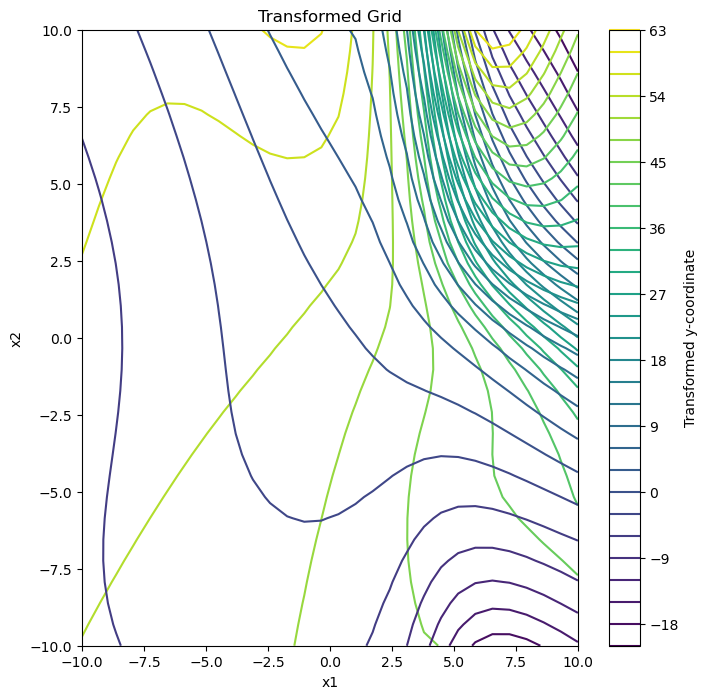

In [165]:
# show the transformed grid
plt.figure(figsize=(8, 8))
plt.contour(X1, X2, X1_transformed, levels=30, cmap='viridis')
plt.contour(X1, X2, X2_transformed, levels=30, cmap='viridis')
plt.colorbar(label='Transformed y-coordinate')
plt.title('Transformed Grid')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

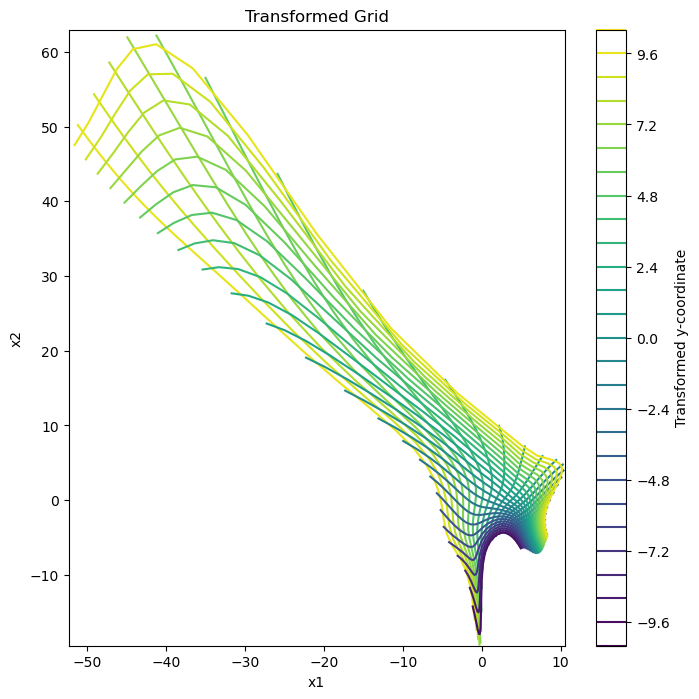

In [166]:
# show the transformed grid
plt.figure(figsize=(8, 8))
plt.contour(X1_transformed, X2_transformed, X1, levels=30, cmap='viridis')
plt.contour(X1_transformed, X2_transformed, X2, levels=30, cmap='viridis')
plt.colorbar(label='Transformed y-coordinate')
plt.title('Transformed Grid')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Optimization in the 2d Real NVP layer

In [167]:
from tqdm import trange

#### SGD / Adam

In [178]:
# Define Gaussian function in transformed space
def gaussian_target(x, mean=torch.zeros(2), std=torch.ones(1)):
    return torch.exp(-0.5 * torch.sum((x - mean)**2, dim=1) / std**2)


# set seed
torch.manual_seed(43)
# Initialize RealNVP model
realnvp = RealNVP_stack(hidden_dim=16, stack_size=10, linear_type="orthogonal_shift", stabilized=True)
# Initialize input point to optimize
x = torch.zeros(1, 2, requires_grad=True)
# Optimize to find maximum of Gaussian
optimizer = torch.optim.SGD([x], lr=0.1)
mean = torch.tensor([1.0, -2.0])
pbar = trange(100)
for i in pbar:
    optimizer.zero_grad()
    # Transform input through RealNVP
    x_transformed, _ = realnvp(x, reverse=False)
    # Compute Gaussian value in transformed space
    loss = -gaussian_target(x_transformed, mean=torch.zeros(2), )  # Negative because we want to maximize
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=-loss.item())


# Get final optimized point
with torch.no_grad():
    x_opt = x.clone()
    x_transformed_opt, _ = realnvp(x_opt, reverse=False)
    print(f"Optimized point in input space: {x_opt.numpy()}")
    print(f"Optimized point in transformed space: {x_transformed_opt.numpy()}")
    print(f"Gaussian value at optimum: {gaussian_target(x_transformed_opt).item()}")

100%|██████████| 100/100 [00:01<00:00, 92.83it/s, loss=0.0452]


Optimized point in input space: [[0.03229344 0.5620917 ]]
Optimized point in transformed space: [[-0.50459826  2.4235427 ]]
Gaussian value at optimum: 0.046696338802576065


In [202]:
# Define Gaussian function in transformed space
def gaussian_target(x, mean=torch.zeros(2), std=torch.ones(1)):
    return torch.exp(-0.5 * torch.sum((x - mean)**2, dim=1) / std**2)


# set seed
torch.manual_seed(43)
# Initialize RealNVP model
realnvp = RealNVP_stack(hidden_dim=16, stack_size=7, linear_type="orthogonal_shift", stabilized=True)
# Initialize input point to optimize
x = torch.randn(1, 2, requires_grad=True)
# Optimize to find maximum of Gaussian
optimizer = torch.optim.SGD([x], lr=0.1)
mean = torch.tensor([1.0, -2.0])
pbar = trange(100)
for i in pbar:
    optimizer.zero_grad()
    # Transform input through RealNVP
    x_transformed, _ = realnvp(x, reverse=False)
    # Compute Gaussian value in transformed space
    loss = -gaussian_target(x_transformed, mean=mean, )  # Negative because we want to maximize
    loss.backward()
    optimizer.step()
    pbar.set_postfix(loss=-loss.item())


# Get final optimized point
with torch.no_grad():
    x_opt = x.clone()
    x_transformed_opt, _ = realnvp(x_opt, reverse=False)
    print(f"Optimized point in input space: {x_opt.numpy()}")
    print(f"Optimized point in transformed space: {x_transformed_opt.numpy()}")
    print(f"Gaussian value at optimum: {gaussian_target(x_transformed_opt).item()}")

100%|██████████| 100/100 [00:00<00:00, 126.55it/s, loss=0.000737]

Optimized point in input space: [[-0.62592703 -0.12368996]]
Optimized point in transformed space: [[1.4860941 1.7665881]]
Gaussian value at optimum: 0.06962338835000992


#### CMAES

In [40]:
from circuit_toolkit.Optimizers import CholeskyCMAES_torch

c:\users\lio50\github\circuit_toolkit\circuit_toolkit\GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [204]:
cma_optimizer = CholeskyCMAES_torch(
    space_dimen=2, init_sigma=0.1, init_code=torch.zeros(2), Aupdate_freq=1, 
    maximize=True, 
)

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.100
cc=0.667, cs=0.515, c1=0.172, damps=1.515


d:\github\dissection_toolkit\circuit_toolkit\Optimizers.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.init_x = torch.tensor(init_code, device=self.device, dtype=torch.float32).reshape(1, N)


In [248]:
optimum = torch.tensor([1.0, -2.0])
x_optimum = realnvp(optimum[None, :].detach().clone(), reverse=True)[0]

In [240]:
optimum = torch.tensor([1.0, -2.0])
x_optimum = realnvp(optimum[None, :], reverse=True)[0]

In [249]:
optimum

tensor([ 1., -2.])

In [242]:
x_optimum

tensor([[-1.5837, -5.6210]], grad_fn=<CatBackward0>)

In [257]:
# Define Gaussian function in transformed space
def gaussian_target(x, mean=torch.zeros(2), std=torch.ones(1)):
    return torch.exp(-0.5 * torch.sum((x - mean)**2, dim=1) / std**2)


# set seed
torch.manual_seed(41)
# Initialize RealNVP model
realnvp = RealNVP_stack(hidden_dim=16, stack_size=10, linear_type="orthogonal_shift", stabilized=True)
# Initialize input point to optimize
x = torch.randn(1, 2, requires_grad=False)
# Optimize to find maximum of Gaussian
cma_optimizer = CholeskyCMAES_torch(
    space_dimen=2, init_sigma=0.5, init_code=x, Aupdate_freq=1, 
    maximize=True, 
)
optimum = torch.tensor([1.0, -2.0])
with torch.no_grad():
    x_optimum = realnvp(optimum[None, :].detach().clone(), reverse=True)[0]
pbar = trange(100)
for i in pbar:
    # Transform input through RealNVP
    x_transformed, _ = realnvp(x, reverse=False)
    # Compute Gaussian value in transformed space
    scores = gaussian_target(x_transformed, mean=optimum, )  # Negative because we want to maximize
    x_next = cma_optimizer.step_simple(scores, x, verbosity=0)
    x = x_next
    pbar.set_postfix(loss=scores.mean().item(), sigma=cma_optimizer.sigma)
    # print("optimum", optimum)
    # print("x_optimum", x_optimum)


# Get final optimized point
with torch.no_grad():
    x_opt = x.mean(dim=0, keepdim=True).clone()
    x_transformed_opt, _ = realnvp(x_opt, reverse=False)
    print(f"Optimized point in input space: {x_opt.numpy()}")
    print(f"Optimized point in transformed space: {x_transformed_opt.numpy()}")
    print(f"Gaussian value at optimum: {gaussian_target(x_transformed_opt, mean=optimum).item()}")
    print(f"desired optimum in x space: {x_optimum}")
    print(f"desired optimum in transformed space: {optimum}")


Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


100%|██████████| 100/100 [00:00<00:00, 160.74it/s, loss=1, sigma=7.54e-5]  

Optimized point in input space: [[-1.5837256 -5.6210704]]
Optimized point in transformed space: [[ 0.99989986 -2.0000088 ]]
Gaussian value at optimum: 1.0
desired optimum in x space: tensor([[-1.5837, -5.6210]])
desired optimum in transformed space: tensor([ 1., -2.])


In [238]:
optimum

tensor([-0.8152, -2.5552], grad_fn=<CopySlices>)

In [235]:
gaussian_target(x_transformed_opt, mean=optimum)

tensor([1.], grad_fn=<ExpBackward0>)

In [234]:
x_optimum

tensor([[-1.5837, -5.6210]], grad_fn=<CatBackward0>)

### ND 

In [9]:
from circuit_toolkit.Optimizers import CholeskyCMAES_torch
from tqdm.auto import trange

c:\users\lio50\github\circuit_toolkit\circuit_toolkit\GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [51]:
# Define Gaussian function in transformed space
def gaussian_target(x, mean=torch.zeros(1), std=torch.ones(1)):
    return torch.exp(-0.5 * torch.sum((x - mean)**2, dim=1) / std**2)


# set seed
torch.manual_seed(41)
dim = 10
# Initialize RealNVP model
realnvp = RealNVPND_stack(dim=dim, hidden_dim=16, stack_size=16, linear_type="orthogonal_shift", stabilized=True, dtype=torch.float64)
# Initialize input point to optimize
x = torch.randn(1, dim, requires_grad=False, dtype=torch.float64)
# Optimize to find maximum of Gaussian
cma_optimizer = CholeskyCMAES_torch(
    space_dimen=dim, init_sigma=0.5, init_code=x, Aupdate_freq=1, 
    maximize=True, dtype=torch.float64, 
)
optimum = torch.ones(dim, dtype=torch.float64)
with torch.no_grad():
    x_optimum, _ = realnvp(optimum[None, :], reverse=True)
print(f"x optimum {x_optimum}")
print(f"latent optimum {optimum}")
torch.manual_seed(torch.seed())
pbar = trange(100)
for i in pbar:
    # Transform input through RealNVP
    x_transformed, _ = realnvp(x, reverse=False)
    # Compute Gaussian value in transformed space
    scores = gaussian_target(x_transformed, mean=optimum, )  # Negative because we want to maximize
    x_next = cma_optimizer.step_simple(scores, x, verbosity=0)
    x = x_next.to(torch.float64)
    pbar.set_postfix(loss=scores.mean().item(), sigma=cma_optimizer.sigma)


# Get final optimized point
with torch.no_grad():
    x_opt = x.mean(dim=0, keepdim=True).clone()
    x_transformed_opt, _ = realnvp(x_opt, reverse=False)
    print(f"Optimized point in input space: {x_opt.numpy()}")
    print(f"Optimized point in transformed space: {x_transformed_opt.numpy()}")
    print(f"Gaussian value at optimum: {gaussian_target(x_transformed_opt, mean=optimum).item()}")
    print(f"desired optimum in x space: {x_optimum}")
    print(f"desired optimum in transformed space: {optimum}")


Space dimension: 10, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.286, cs=0.387, c1=0.015, damps=1.387
x optimum tensor([[ 5.0936, -1.6560, -1.8258,  0.5672,  3.5259, -6.3583, -2.0368, -2.3873,
         10.4373,  3.6820]], dtype=torch.float64)
latent optimum tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)


  0%|          | 0/100 [00:00<?, ?it/s]

Optimized point in input space: [[ 5.15788908 -1.64873237 -1.81484363  0.50889583  3.59041129 -6.43373577
  -2.07690813 -2.27330534 10.3974328   3.77775695]]
Optimized point in transformed space: [[1.06316237 0.99770083 0.95034737 0.98948156 1.00911821 1.04066663
  1.00232208 0.98192186 1.14680432 1.03680289]]
Gaussian value at optimum: 0.9843508009273197
desired optimum in x space: tensor([[ 5.0936, -1.6560, -1.8258,  0.5672,  3.5259, -6.3583, -2.0368, -2.3873,
         10.4373,  3.6820]], dtype=torch.float64)
desired optimum in transformed space: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)


### Massive ND Real NVP experiment

In [8]:
def run_optimization_experiment(dim=10, stack_size=16, hidden_dim=16, skip_nonlinear=False, network_seed=41, optim_seed=None,
                                max_steps=100, verbosity=2):
    # Define Gaussian function in transformed space
    def gaussian_target(x, mean=torch.zeros(1), std=torch.ones(1)):
        return torch.exp(-0.5 * torch.sum((x - mean)**2, dim=1) / std**2)

    if stack_size == 0: 
        skip_nonlinear = True
    
    # Initialize RealNVP model
    if skip_nonlinear:
        realnvp = lambda x, reverse: (x, 0)
    else:
        # set seed
        torch.manual_seed(network_seed)
        realnvp = RealNVPND_stack(dim=dim, hidden_dim=hidden_dim, stack_size=stack_size, 
                             linear_type="orthogonal_shift", stabilized=True, dtype=torch.float64)
    
    # Initialize input point to optimize
    x = torch.randn(1, dim, requires_grad=False, dtype=torch.float64)
    
    # Optimize to find maximum of Gaussian
    cma_optimizer = CholeskyCMAES_torch(
        space_dimen=dim, init_sigma=0.5, init_code=x, Aupdate_freq=1,
        maximize=True, dtype=torch.float64,
    )
    
    optimum = torch.ones(dim, dtype=torch.float64)
    with torch.no_grad():
        x_optimum, _ = realnvp(optimum[None, :], reverse=True)
    if verbosity >= 2: 
        print(f"latent optimum {optimum}")
        print(f"x optimum {x_optimum}")
    
    # Reset seed for optimization
    torch.manual_seed(torch.seed() if optim_seed is None else optim_seed)
    pbar = trange(max_steps)
    generations = []
    scores_all = []
    for i in pbar:
        x_transformed, _ = realnvp(x, reverse=False)
        scores = gaussian_target(x_transformed, mean=optimum)
        x_next = cma_optimizer.step_simple(scores, x, verbosity=0)
        x = x_next.to(torch.float64)
        pbar.set_postfix(loss=scores.mean().item(), sigma=cma_optimizer.sigma)
        scores_all.append(scores)
        generations.extend([i]*len(scores))

    scores_all = torch.concat(scores_all, dim=0)
    # Get final results
    results = {}
    results["scores_all"] = scores_all
    results["generations"] = torch.tensor(generations)
    with torch.no_grad():
        x_opt = x.mean(dim=0, keepdim=True).clone()
        x_transformed_opt, _ = realnvp(x_opt, reverse=False)
        results['input_space_optimum'] = x_opt.numpy()
        results['transformed_space_optimum'] = x_transformed_opt.numpy()
        results['gaussian_value'] = gaussian_target(x_transformed_opt, mean=optimum).item()
        results['desired_x_optimum'] = x_optimum.numpy()
        results['desired_transformed_optimum'] = optimum.numpy()
        
        if verbosity >= 2: 
            print(f"Optimized point in input space: {results['input_space_optimum']}")
            print(f"Optimized point in transformed space: {results['transformed_space_optimum']}")
            print(f"Gaussian value at optimum: {results['gaussian_value']}")
            print(f"desired optimum in x space: {results['desired_x_optimum']}")
            print(f"desired optimum in transformed space: {results['desired_transformed_optimum']}")
        
    return results


In [10]:
# Example usage:
dims_to_test = [2, 4, 8, 16, 32, 64, 128, ]
stack_sizes = [0, 2, 4, 8, 16, 32, 48, 64]
seeds = range(40, 50)

results_dict = {}
for dim in dims_to_test:
    for stack in stack_sizes:
        for seed in seeds:
            key = f"dim{dim}_stack{stack}_seed{seed}"
            results_dict[key] = run_optimization_experiment(
                dim=dim, 
                stack_size=stack,
                network_seed=seed,
                verbosity=0
            )


Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


c:\users\lio50\github\circuit_toolkit\circuit_toolkit\Optimizers.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.init_x = torch.tensor(init_code, device=self.device, dtype=self.dtype).reshape(1, N)


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 2, Population size: 7, Select size:3, Optimization Parameters:
Initial sigma: 0.500
cc=0.667, cs=0.515, c1=0.172, damps=1.515


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 4, Population size: 10, Select size:5, Optimization Parameters:
Initial sigma: 0.500
cc=0.500, cs=0.471, c1=0.068, damps=1.471


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 8, Population size: 13, Select size:6, Optimization Parameters:
Initial sigma: 0.500
cc=0.333, cs=0.414, c1=0.023, damps=1.414


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 16, Population size: 16, Select size:8, Optimization Parameters:
Initial sigma: 0.500
cc=0.200, cs=0.355, c1=0.007, damps=1.355


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 32, Population size: 19, Select size:9, Optimization Parameters:
Initial sigma: 0.500
cc=0.111, cs=0.296, c1=0.002, damps=1.296


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

Space dimension: 64, Population size: 22, Select size:11, Optimization Parameters:
Initial sigma: 0.500
cc=0.059, cs=0.241, c1=0.000, damps=1.241


  0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
import seaborn as sns
import pandas as pd

# Create DataFrame from results
records = []
for key, result in results_dict.items():
    dim, stack, seed = key.replace('dim','').replace('stack','').replace('seed','').split('_')
    record = {
        'dimension': int(dim),
        'stack_size': int(stack), 
        'seed': int(seed),
        'gaussian_value': result['gaussian_value'],
        'input_space_optimum': result['input_space_optimum'],
        'transformed_space_optimum': result['transformed_space_optimum'],
        'desired_x_optimum': result['desired_x_optimum'],
        'desired_transformed_optimum': result['desired_transformed_optimum']
    }
    records.append(record)
    
results_df = pd.DataFrame.from_records(records)

In [70]:
results_df

,dimension,stack_size,seed,gaussian_value,input_space_optimum,transformed_space_optimum,desired_x_optimum,desired_transformed_optimum
0,2,0,40,1.0,"[[0.9999999951605821, 1.00000000304062]]","[[0.9999999951605821, 1.00000000304062]]","[[1.0, 1.0]]","[1.0, 1.0]"
1,2,0,41,1.0,"[[0.9999999954539397, 1.0000000022493676]]","[[0.9999999954539397, 1.0000000022493676]]","[[1.0, 1.0]]","[1.0, 1.0]"
2,2,0,42,1.0,"[[0.9999999981842945, 1.000000004803517]]","[[0.9999999981842945, 1.000000004803517]]","[[1.0, 1.0]]","[1.0, 1.0]"
3,2,0,43,1.0,"[[1.0000000008273762, 0.9999999912931029]]","[[1.0000000008273762, 0.9999999912931029]]","[[1.0, 1.0]]","[1.0, 1.0]"
4,2,0,44,1.0,"[[0.9999999967723239, 0.9999999883584539]]","[[0.9999999967723239, 0.9999999883584539]]","[[1.0, 1.0]]","[1.0, 1.0]"
...,...,...,...,...,...,...,...,...
175,100,64,40,0.0,"[[-1.7998676554164947, -2.7275111404534518, 3....","[[-1583674121.85558, 1150947539.5163677, 19524...","[[-132222918.49147575, -164437664.28411093, -1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
176,100,64,41,0.0,"[[-1.5040454127145575, -1.8608467387671666, -1...","[[2298928243.7879376, -694584008.9046452, -299...","[[-39073579.50272219, -41850463.8452535, 22411...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
177,100,64,42,0.0,"[[-0.39658724793941086, -0.3095253805756855, 1...","[[2357333906.64259, 3600889123.8618016, 148244...","[[502972519.46825784, 479073196.3423907, 48522...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
178,100,64,43,0.0,"[[1.3281995134023343, -1.027563122670577, -3.0...","[[9487958154.126812, 7675674351.625174, 116925...","[[-902359344.6251062, 574968863.5621687, -9488...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


<Axes: xlabel='stack_size', ylabel='gaussian_value'>

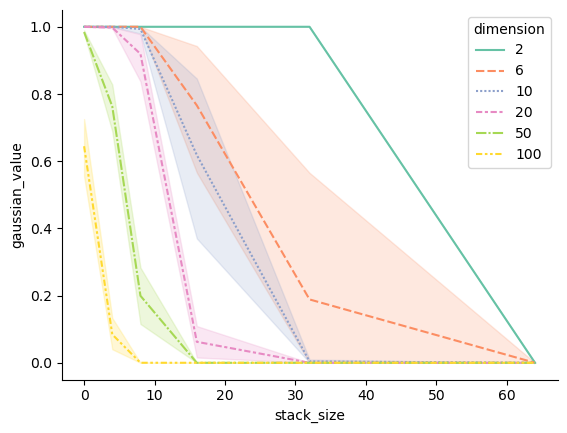

In [74]:
sns.lineplot(data=results_df, y="gaussian_value", x="stack_size", hue="dimension", style="dimension", palette="Set2")